In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
filename = 'jena_climate_2009_2016.csv'
f = open(filename)
data = f.read()
f.close()

In [3]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [4]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

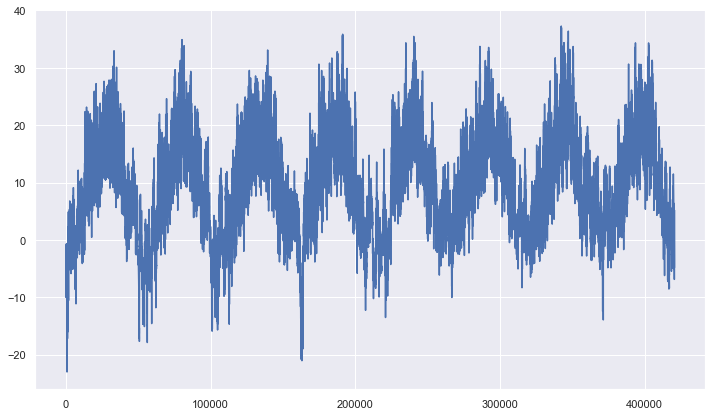

In [5]:
temp = float_data[:, 1]
plt.figure(figsize=(12,7))
plt.plot(range(len(temp)), temp);

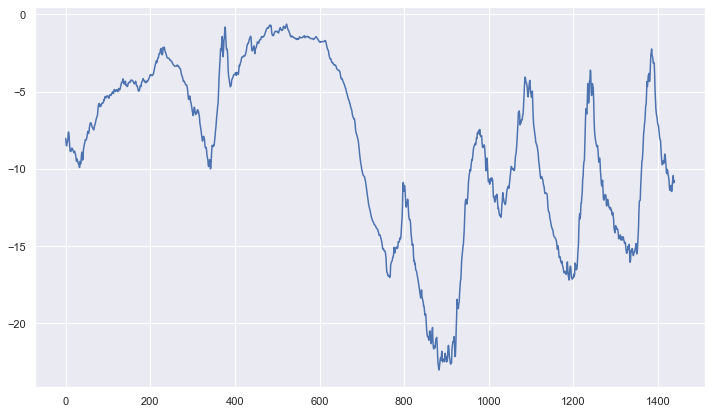

In [6]:
plt.figure(figsize=(12,7))
plt.plot(range(1440), temp[:1440]);

In [7]:
lockback = 720
step = 6
delay = 144

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets           

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)


val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size
#np.mean(np.abs(preds - targets))

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in np.arange(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [12]:
evaluate_naive_method()

0.2897359729905486


In [13]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

W0818 00:13:16.080997  2812 deprecation_wrapper.py:119] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 00:13:16.097999  2812 deprecation_wrapper.py:119] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 00:13:16.104996  2812 deprecation_wrapper.py:119] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [14]:
model.compile(optimizer=RMSprop(), loss='mae')

W0818 00:13:16.137999  2812 deprecation_wrapper.py:119] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [15]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

W0818 00:13:16.224998  2812 deprecation_wrapper.py:119] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0818 00:13:16.228999  2812 deprecation_wrapper.py:119] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
500/500 [==============================] - 12s 23ms/step - loss: 1.2918 - val_loss: 0.5463
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.4137 - val_loss: 0.3397
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2887 - val_loss: 0.3111
Epoch 4/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2652 - val_loss: 0.2968
Epoch 5/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2518 - val_loss: 0.3137
Epoch 6/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2436 - val_loss: 0.3251
Epoch 7/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2385 - val_loss: 0.3156
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2327 - val_loss: 0.3261
Epoch 9/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2297 - val_loss: 0.3764
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.225

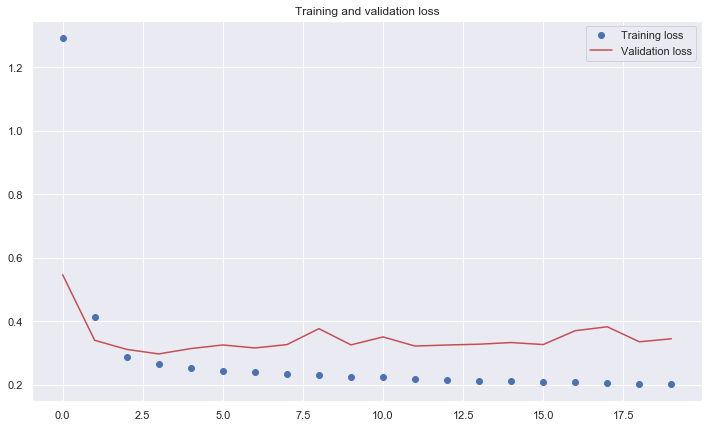

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(12,7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend();